## PID Velocity Controller For a Car

A self-driving car company has requested a speed controller for their new model of electric autonomous vehicles. Unlike standard cruise control systems, this speed controller must manage transitions between all velocities ranging from 0 to 25 m/s (56 mph or 90 km/hr).


The speed controller changes a gas pedal (%) input that adjusts electrical current to the motor, creates a torque on the drive train, applies forward thrust from wheel contact on the road, and changes the velocity of the vehicle. Regenerative braking is part of this application by allowing the gas pedal to go from -50% to 100%. Decreases in velocity are also due to resistive forces. Negative velocities (backwards driving) is highly undesirable.


Simulation Time : 100 secs time Step : 1s

We call the controller safe if velocity range stays within 0 to 25

We want to find Parameter Values For our Disturbance Variable : Load where this property is not satisfied.

## Velocity Dynamics

with m as the mass in the vehicle and passengers and v as the velocity of the automobile. Assuming constant mass of the vehicle, a constant drag coefficient, Cd, and a linear gain between gas pedal position and force, the momentum balance becomes

m X dv(t)/dt=(Fp x u(t))−(0.5 x ρ x A x Cd x (v(t)^2)) [where m = car_weight + cargo_weight]

=>dv(t)/dt=(1/m) x ((Fp x u(t))−(0.5 x ρ x A x Cd x (v(t)^2)))

with u(t) as gas pedal position(%pedal), v(t) as velocity (m/s), m as the mass of the vehicle (500 kg) plus the mass of the passengers and cargo (50-100 kg), Cd as the drag coefficient (0.24), ρ as the air density (1.225 kg/m3), A as the vehicle cross-sectional area (5 m2), and Fp as the thrust parameter (30 N/%pedal).

## Control System Design

Cruise Control

OP: Actuator- Gas Pedal Position

CV: Controller- Set Point Desired Speed (mph or km/hr)

PV: Measurement- (Sensor)Speedometer, measured velocity

DV: Disturbance variables - Hills, wind, cargo + passenger load

e(t) = SP - PV

u(t) = ubias + Kce(t) + Kc/Tisum(ei(t))

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint  
import GPy
import GPyOpt
from numpy.random import seed


# for storing the results
vs = np.zeros(101)

# define Vehicle model
def vehicle(v,t,u,load):
    # inputs
    #  v    = vehicle velocity (m/s)
    #  t    = time (sec)
    #  u    = gas pedal position (-50% to 100%)
    #  load = passenger load + cargo (kg)
    Cd = 0.24    # drag coefficient
    rho = 1.225  # air density (kg/m^3)
    A = 5.0      # cross-sectional area (m^2)
    Fp = 30      # thrust parameter (N/%pedal)
    m = 500      # vehicle mass (kg)
    # calculate derivative of the velocity
    dv_dt = (1.0/(m+load)) * (Fp*u - 0.5*rho*Cd*A*v**2)
    return dv_dt

    #Controller Model
def controller_model(load):
    tf = 100.0                 # final time for simulation
    nsteps = 101               # number of time steps
    delta_t = tf/(nsteps-1)   # how long is each time step?
    ts = np.linspace(0,tf,nsteps) # linearly spaced time vector

    # simulate step test operation
    step = np.zeros(nsteps) # u = valve % open
    #step[11:] = 50.0       # step up pedal position
    # passenger(s) + cargo load
    #load = 100.0 # kg
    # velocity initial condition
    v0 = 0.00

    ubias = 0.0
    Kc = 1.0/1.2 * 27.0
    tauI = 30.0
    sum_int = 0.0
    es = np.zeros(nsteps)
    ies = np.zeros(nsteps)

    sp_store = np.zeros(nsteps)
    sp = 25

    # simulate with ODEINT
    for i in range(nsteps-1):
        if i == 20:
            sp = 0;
        if i == 40:
            sp = 15
        if i == 50:
            sp = 20
        if i == 80:
            sp = 10

        sp_store[i+1] = sp
        error = sp - v0
        es[i+1] = error
        sum_int = sum_int + error*delta_t
        ies[i+1] = sum_int
        u = ubias + Kc*error + Kc/tauI * sum_int        #PI controller for changing the gas pedal
        step[i+1] = u
        # clip inputs to -50% to 100%
        if u >= 100.0:
            u = 100.0
            sum_int = sum_int - error*delta_t
        if u <= -50.0:
            u = -50.0
            sum_int = sum_int - error*delta_t
        v = odeint(vehicle,v0,[0,delta_t],args=(u,load))
        v0 = v[-1]   # take the last value
        vs[i+1] = v0 # store the velocity for plotting

vel = controller_model(0)

print(str(vs))
print('=========Minimum velocity Value'+str(min(vs)))

[ 0.          5.98242207 11.86084339 17.53837221 22.93132465 24.97244434
 24.21509999 24.53097287 24.43385654 24.49456527 24.4939273  24.51613734
 24.52888234 24.54459441 24.55851992 24.57250496 24.58586019 24.59886946
 24.61144223 24.62363118 24.63543342 20.87397085 17.33679486 13.97568127
 10.75008593  7.62499587  4.56928657  1.55441256 -0.21960116  0.41216288
  0.17242803  0.24864271  0.21076678  0.21455012  0.20357341  0.19825938
  0.19120121  0.18507123  0.17889187  0.17300769  0.16728476  6.14819963
 12.02228421 16.11058533 14.57708131 15.15397516 14.93737444 15.01893895
 14.98843273 15.00004077 14.99581569 20.527068   19.52881842 19.91694099
 19.77776039 19.83869956 19.82332373 19.83670628 19.83891898 19.84514595
 19.84962308 19.85454859 19.85909365 19.86358002 19.86789182 19.87207935
 19.87612953 19.88005319 19.88385186 19.88753046 19.89109242 19.89454159
 19.89788148 19.90111558 19.90424724 19.9072799  19.91021623 19.91305965
 19.91581296 19.91847908 19.92106075 16.43466243 13

## Plotting Module

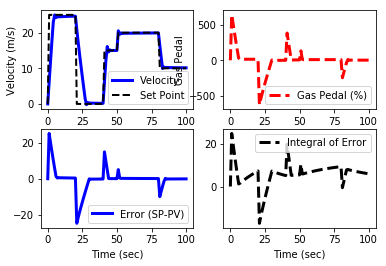

In [202]:
# plot results
plt.figure()
plt.subplot(2,2,1)
plt.plot(ts,vs,'b-',linewidth=3)
plt.plot(ts,sp_store,'k--',linewidth=2)
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (sec)')
plt.legend(['Velocity','Set Point'],loc='best')
plt.subplot(2,2,2)
plt.plot(ts,step,'r--',linewidth=3)
plt.ylabel('Gas Pedal')    
plt.legend(['Gas Pedal (%)'])
plt.xlabel('Time (sec)')
plt.subplot(2,2,3)
plt.plot(ts,es,'b-',linewidth=3)   
plt.legend(['Error (SP-PV)'])
plt.xlabel('Time (sec)')
plt.subplot(2,2,4)
plt.plot(ts,ies,'k--',linewidth=3)  
plt.legend(['Integral of Error'])
plt.xlabel('Time (sec)')
plt.show()

## Bayesian Optimization Module

Bayesian Optimization taking time as a trajectory

In [203]:
#Function defination of minimizing distance
#Position of car minus the distance if it is less than 0 there is a collision
def find_param(bounds):
    load = bounds[0][0]
    controller_model(load)
    print(' ====weight==='+str(load)+' ====velocity==='+str(min(vs)))
    return min(vs)
    '''l = map(lambda x: x * -1, vs)
    print(str(min(l)))
    return min(l)'''


#Domain of uncertainity position of car
bounds = [{'name': 'load', 'type': 'continuous', 'domain': (0,500)}]
#Budget number of evaluations of f
max_iter = 250
# Creates GPyOpt object with the model and acquisition fucntion
seed(123)
myProblem = GPyOpt.methods.BayesianOptimization(find_param,     # function to optimize  
                                                bounds,  # box-constraints of the problem
                                                acquisition_type='EI',
                                                exact_feval = True) # Selects the Expected improvement
max_time = 250     # time budget 
eps      = 10e-10  # Minimum allowed distance between the last two observations

myProblem.run_optimization(max_iter, max_time, eps)

 ====weight===348.2345927989308 ====velocity===0.0
 ====weight===143.06966747518973 ====velocity===0.0
 ====weight===113.42572678210155 ====velocity===0.0
 ====weight===275.6573845414456 ====velocity===0.0
 ====weight===359.73448489278155 ====velocity===0.0
 ====weight===137.11250572902262 ====velocity===0.0
 ====weight===131.0793628038542 ====velocity===0.0
 ====weight===350.3270652580232 ====velocity===0.0
 ====weight===416.6360505879051 ====velocity===0.0
 ====weight===280.3720898286889 ====velocity===0.0
 ====weight===115.1216760834799 ====velocity===0.0
 ====weight===278.6853216391425 ====velocity===0.0
 ====weight===267.2561758253148 ====velocity===0.0
 ====weight===245.98680144014833 ====velocity===0.0
 ====weight===113.04105285173965 ====velocity===0.0
 ====weight===379.7580296126529 ====velocity===0.0
 ====weight===350.5880390133995 ====velocity===0.0
 ====weight===275.9859744327854 ====velocity===0.0
 ====weight===156.97786058985608 ====velocity===0.0
 ====weight===394.072902

 ====weight===23.99884008921932 ====velocity===-0.3355656153067399
 ====weight===69.80715474561022 ====velocity===-0.03328001181006146
 ====weight===21.78158208552827 ====velocity===-0.4272528345973051
 ====weight===21.810808607775346 ====velocity===-0.4274540005385762
 ====weight===12.394243672279925 ====velocity===-0.3523797817535569
 ====weight===140.03076025094802 ====velocity===0.0
 ====weight===413.8685070596119 ====velocity===0.0
 ====weight===491.37739755603303 ====velocity===0.0
 ====weight===109.55731925536311 ====velocity===0.0
 ====weight===264.2152542524645 ====velocity===0.0
 ====weight===21.717444084317027 ====velocity===-0.42681070115811637
 ====weight===21.84752900335568 ====velocity===-0.427706475122244
 ====weight===53.730812691456464 ====velocity===0.0
 ====weight===408.269508453897 ====velocity===0.0
 ====weight===434.5865477236595 ====velocity===0.0
 ====weight===454.6395122883693 ====velocity===0.0
 ====weight===64.06749223094704 ====velocity===-0.001490568206956

In [204]:
myProblem.x_opt

array([21.91031096])

In [205]:
myProblem.fx_opt

-0.42813743806477655

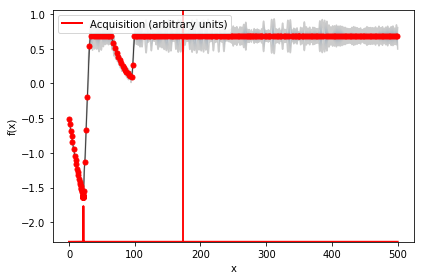

In [206]:
myProblem.plot_acquisition()

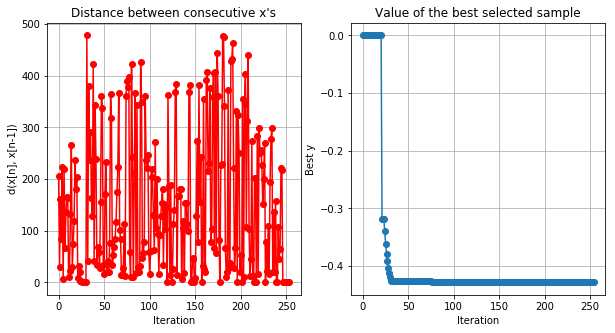

In [207]:
myProblem.plot_convergence()